# Udacity Deep Reinforcement Learning Nanodegree - Project 1: Navigation

In [1]:
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import torch
from unityagents import UnityEnvironment

from agent import Agent
from utils import sample_experience_tuples

## Set everything up

* Unity environment
* Hyperparameters
* Agent

In [2]:
env = UnityEnvironment(file_name="Banana.app")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
hyperparams = {'eps_start': 1.0,
               'eps_min': 0.01,
               'eps_decay': 0.995,
               'learn_rate': 5e-4,
               'batch_size': 64,
               'gamma': 0.99,
               'update_interval': 4,
               'tau': 1e-3}

In [4]:
state_size = env.reset(train_mode=False)[brain_name].vector_observations[0].shape[0]
action_size = brain.vector_action_space_size

agent = Agent(state_size=state_size,
              action_size=action_size,
              seed=42, hyperparams=hyperparams)

## Train the Agent with Deep Q-Learning

In [5]:
def perform_dqn_training(env, brain_name, agent, hyperparams,
                         solution_threshold, n_episodes, max_steps):
    """
    Performs Deep Q-Learning Algorithm
    for a given agent wrt a proper environment
    
    Args:
        env (unityagents.environment.UnityEnvironment): environment
        brain_name (str): brain name (required for environment)
        agent (agent.Agent): Agent that chooses actions wrt an epsilon-greedy policy
            using action values obtained by a deep neural network
        hyperparams (dict): Hyperparameters for agent and training
        solution_threshold (float): average score threshold to reach for solution
        n_episodes (int): number of episodes for which the agent performs an episodic task
        max_steps (int): maximum number of steps within a single episode
        
    Returns:
        scores ([float]): list of cumulative rewards for each episode 
    """
    scores = []
    window_length = 100
    env_is_solved = False
    scores_window = deque(maxlen=window_length)
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        
        # Perform single episode up to `max_steps`
        for t in range(max_steps):
            action = agent.get_action(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        
        agent.update_epsilon(hyperparams['eps_decay'])
        scores_window.append(score)
        scores.append(score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % window_length == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if (np.mean(scores_window) >= solution_threshold) & (not env_is_solved):
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode,
                                                                                         np.mean(scores_window)))
            env_is_solved = True
        
        # Store weights for the best performing agent
        if env_is_solved & (score == max(scores)):
            torch.save(agent.q_network.state_dict(), 'best_banana_picker_agent.pth')
            
    return scores

In [6]:
scores = perform_dqn_training(env, brain_name, agent, hyperparams,
                              solution_threshold=13.0,
                              n_episodes=1000,
                              max_steps=1000)
env.close()

Episode 100	Average Score: 1.38
Episode 200	Average Score: 5.79
Episode 300	Average Score: 8.42
Episode 400	Average Score: 10.89
Episode 500	Average Score: 12.32
Episode 538	Average Score: 13.02
Environment solved in 538 episodes!	Average Score: 13.02
Episode 600	Average Score: 12.84
Episode 700	Average Score: 13.43
Episode 800	Average Score: 13.36
Episode 900	Average Score: 14.57
Episode 1000	Average Score: 14.61


## Performance Plot

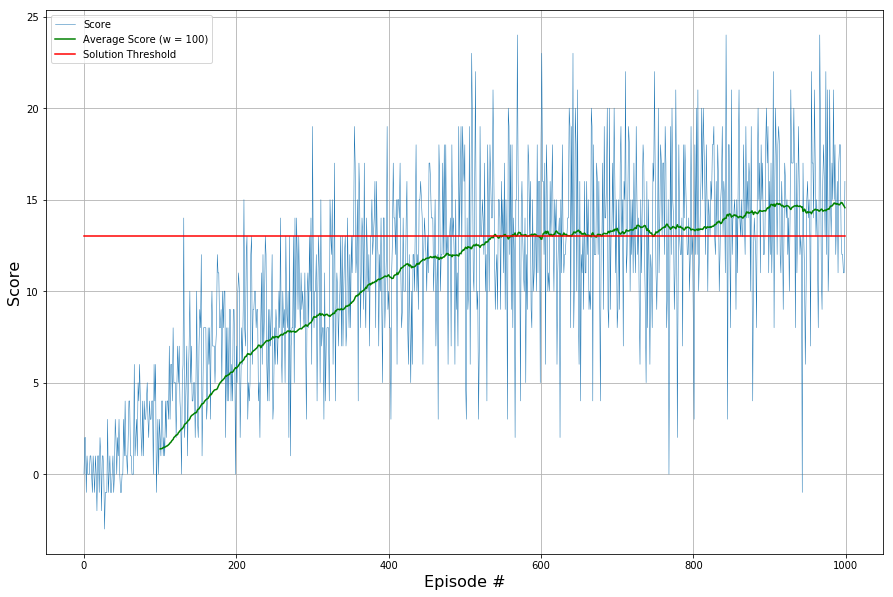

In [7]:
solution_threshold = 13
window_length = 100
average_scores = np.array([np.mean(scores[i:(i+window_length)])
                           for i in range(len(scores)-window_length)])

fig = plt.figure(figsize=(15, 10))
plt.plot(np.arange(len(scores)), scores, linewidth=0.5)
plt.plot(np.arange(window_length, len(scores)), average_scores, 'g-')
plt.plot(np.arange(len(scores)), [solution_threshold]*len(scores), 'r-')
plt.ylabel('Score', fontsize=16)
plt.xlabel('Episode #', fontsize=16)
plt.legend(['Score', 'Average Score (w = 100)', 'Solution Threshold'])
plt.grid(True)
plt.show()

In [8]:
print("Environment was solved in Episode {}!".format(np.argmax((average_scores >= solution_threshold))+window_length))

Environment was solved in Episode 538!
